## Word Tokenizer exercise##

In this exercise, you are going to build a set of deep learning models on a (sort of) real world task using pyTorch. PyTorch is a deep learning framwork developed by facebook to provide an easier way to use standard layers and networks.

To complete this exercise, you will need to build deep learning models for word tokenization in Thai (ตัดคำภาษาไทย) using NECTEC's BEST corpus. You will build one model for each of the following type:
- Fully Connected (Feedforward) Neural Network
- One-Dimentional Convolution Neural Network (1D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

**Don't forget to change hardware accelerator to GPU in Google Colab.**


In [ ]:
!pip install wandb torchinfo huggingface_hub lightning

In [ ]:
# Run setup code
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from sklearn.metrics import accuracy_score
from huggingface_hub import hf_hub_download
from tqdm import tqdm

%matplotlib inline

# To guarantee reproducible results
torch.manual_seed(5420)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(5420)

## Wandb Setup

We also encourage you to use Wandb which will help you log and visualize your training process.

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [ ]:
!wandb login

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

In [ ]:
#Check GPU is available
torch.cuda.device_count()

1

In [ ]:
#Download dataset
hf_hub_download(repo_id="iristun/corpora", filename="corpora.tar.gz", repo_type="dataset", local_dir=".")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


'corpora.tar.gz'

In [ ]:
!tar xvf corpora.tar.gz

corpora/
corpora/mnist_data/
corpora/mnist_data/t10k-images-idx3-ubyte.gz
corpora/mnist_data/train-images-idx3-ubyte.gz
corpora/mnist_data/.ipynb_checkpoints/
corpora/mnist_data/vis_utils.py
corpora/mnist_data/__init__.py
corpora/mnist_data/load_mnist.py
corpora/mnist_data/train-labels-idx1-ubyte.gz
corpora/mnist_data/t10k-labels-idx1-ubyte.gz
corpora/BEST/
corpora/BEST/test/
corpora/BEST/test/df_best_article_test.csv
corpora/BEST/test/df_best_encyclopedia_test.csv
corpora/BEST/test/df_best_novel_test.csv
corpora/BEST/test/df_best_news_test.csv
corpora/BEST/train/
corpora/BEST/train/df_best_encyclopedia_train.csv
corpora/BEST/train/df_best_article_train.csv
corpora/BEST/train/df_best_news_train.csv
corpora/BEST/train/df_best_novel_train.csv
corpora/BEST/val/
corpora/BEST/val/df_best_encyclopedia_val.csv
corpora/BEST/val/df_best_news_val.csv
corpora/BEST/val/df_best_article_val.csv
corpora/BEST/val/df_best_novel_val.csv
corpora/.ipynb_checkpoints/
corpora/.ipynb_checkpoints/Word_Tokeniz

For simplicity, we are going to build a word tokenization model which is a binary classification model trying to predict whether a character is the begining of the word or not (if it is, then there is a space in front of it) and without using any knowledge about type of character (vowel, number, English character etc.).

For example,

'แมวดำน่ารักมาก' -> 'แมว ดำ น่า รัก มาก'

will have these true labels:

[(แ,1), (ม,0), (ว,0) (ด,1), ( ำ,0), (น,1), (-่,0), (า,0), (ร,1), (-ั,0), (ก,0), (ม,1), (า,0), (ก,0)]

In this task, we will use only main character you are trying to predict  and the characters that surround it (the context) as features. However, you can imagine that a more complex model will try to include more knowledge about each character into the model. You can do that too if you feel like it.

In [ ]:
# Create a character map
CHARS = [
  '\n', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+',
  ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8',
  '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E',
  'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R',
  'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_',
  'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
  'n', 'o', 'other', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
  'z', '}', '~', 'ก', 'ข', 'ฃ', 'ค', 'ฅ', 'ฆ', 'ง', 'จ', 'ฉ', 'ช',
  'ซ', 'ฌ', 'ญ', 'ฎ', 'ฏ', 'ฐ', 'ฑ', 'ฒ', 'ณ', 'ด', 'ต', 'ถ', 'ท',
  'ธ', 'น', 'บ', 'ป', 'ผ', 'ฝ', 'พ', 'ฟ', 'ภ', 'ม', 'ย', 'ร', 'ฤ',
  'ล', 'ว', 'ศ', 'ษ', 'ส', 'ห', 'ฬ', 'อ', 'ฮ', 'ฯ', 'ะ', 'ั', 'า',
  'ำ', 'ิ', 'ี', 'ึ', 'ื', 'ุ', 'ู', 'ฺ', 'เ', 'แ', 'โ', 'ใ', 'ไ',
  'ๅ', 'ๆ', '็', '่', '้', '๊', '๋', '์', 'ํ', '๐', '๑', '๒', '๓',
  '๔', '๕', '๖', '๗', '๘', '๙', '‘', '’', '\ufeff'
]
CHARS_MAP = {v: k for k, v in enumerate(CHARS)}

In [ ]:
def create_n_gram_df(df, n_pad):
  """
  Given an input dataframe, create a feature dataframe of shifted characters
  Input:
  df: timeseries of size (N)
  n_pad: the number of context. For a given character at position [idx],
    character at position [idx-n_pad/2 : idx+n_pad/2] will be used
    as features for that character.

  Output:
  dataframe of size (N * n_pad) which each row contains the character,
    n_pad_2 characters to the left, and n_pad_2 characters to the right
    of that character.
  """
  n_pad_2 = int((n_pad - 1)/2)
  for i in range(n_pad_2):
      df['char-{}'.format(i+1)] = df['char'].shift(i + 1)
      df['char{}'.format(i+1)] = df['char'].shift(-i - 1)
  return df[n_pad_2: -n_pad_2]

In [ ]:
def prepare_feature(best_processed_path, option='train'):
  """
  Transform the path to a directory containing processed files
  into a feature matrix and output array
  Input:
  best_processed_path: str, path to a processed version of the BEST dataset
  option: str, 'train' or 'test'
  """
  # we use padding equals 21 here to consider 10 characters to the left
  # and 10 characters to the right as features for the character in the middle
  n_pad = 21
  n_pad_2 = int((n_pad - 1)/2)
  pad = [{'char': ' ', 'target': True}]
  df_pad = pd.DataFrame(pad * n_pad_2)

  df = []
  # article types in BEST corpus
  article_types = ['article', 'encyclopedia', 'news', 'novel']
  for article_type in article_types:
      df.append(pd.read_csv(os.path.join(best_processed_path, option, 'df_best_{}_{}.csv'.format(article_type, option))))

  df = pd.concat(df)
  # pad with empty string feature
  df = pd.concat((df_pad, df, df_pad))

  # map characters to numbers, use 'other' if not in the predefined character set.
  df['char'] = df['char'].map(lambda x: CHARS_MAP.get(x, 80))

  # Use nearby characters as features
  df_with_context = create_n_gram_df(df, n_pad=n_pad)

  char_row = ['char' + str(i + 1) for i in range(n_pad_2)] + \
             ['char-' + str(i + 1) for i in range(n_pad_2)] + ['char']

  # convert pandas dataframe to numpy array to feed to the model
  x_char = df_with_context[char_row].to_numpy()
  y = df_with_context['target'].astype(int).to_numpy()

  return x_char, y

Before running the following commands, we must inform you that our data is quite large and loading the whole dataset at once will **use a lot of memory (~6 GB after processing and up to ~12GB while processing)**. We expect you to be running this on Google Cloud or Google Colab so that you will not run into this problem. But, if, for any reason, you have to run this on your PC or machine with not enough memory, you might need to write a data generator to process a few entries at a time then feed it to the model while training.


In [ ]:
# Path to the preprocessed data
best_processed_path = 'corpora/BEST'

In [ ]:
# Load preprocessed BEST corpus
x_train_char, y_train = prepare_feature(best_processed_path, option='train')
x_val_char, y_val = prepare_feature(best_processed_path, option='val')
x_test_char, y_test = prepare_feature(best_processed_path, option='test')

# As a sanity check, we print out the size of the training, val, and test data.
print('Training data shape: ', x_train_char.shape)
print('Training data labels shape: ', y_train.shape)
print('Validation data shape: ', x_val_char.shape)
print('Validation data labels shape: ', y_val.shape)
print('Test data shape: ', x_test_char.shape)
print('Test data labels shape: ', y_test.shape)

Training data shape:  (16461637, 21)
Training data labels shape:  (16461637,)
Validation data shape:  (2035694, 21)
Validation data labels shape:  (2035694,)
Test data shape:  (2271932, 21)
Test data labels shape:  (2271932,)


In [ ]:
# Print some entry from the data to make sure it is the same as what you think.
print('First 3 features: ', x_train_char[:3])
print('First 30 class labels', y_train[:30])

First 3 features:  [[112. 140. 114. 148. 130. 142.  94. 142. 128. 128.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.  97.]
 [140. 114. 148. 130. 142.  94. 142. 128. 128. 141.  97.   1.   1.   1.
    1.   1.   1.   1.   1.   1. 112.]
 [114. 148. 130. 142.  94. 142. 128. 128. 141. 109. 112.  97.   1.   1.
    1.   1.   1.   1.   1.   1. 140.]]
First 30 class labels [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


In [ ]:
#print char of feature 1
char = np.array(CHARS)

#A function for displaying our features in text
def print_features(tfeature,label,index):
    feature = np.array(tfeature[index],dtype=int).reshape(21,1)
    #Convert to string
    char_list = char[feature]
    left = ''.join(reversed(char_list[10:20].reshape(10))).replace(" ", "")
    center = ''.join(char_list[20])
    right =  ''.join(char_list[0:10].reshape(10)).replace(" ", "")
    word = ''.join([left,' ',center,' ',right])
    print(center + ': ' + word + "\tpred = "+str(label[index]))

for ind in range(0,30):
    print_features(x_train_char,y_train,ind)

ค:  ค ณะตุลาการร	pred = 1
ณ: ค ณ ะตุลาการรั	pred = 0
ะ: คณ ะ ตุลาการรัฐ	pred = 0
ต: คณะ ต ุลาการรัฐธ	pred = 0
ุ: คณะต ุ ลาการรัฐธร	pred = 0
ล: คณะตุ ล าการรัฐธรร	pred = 0
า: คณะตุล า การรัฐธรรม	pred = 0
ก: คณะตุลา ก ารรัฐธรรมน	pred = 0
า: คณะตุลาก า รรัฐธรรมนู	pred = 0
ร: คณะตุลากา ร รัฐธรรมนูญ	pred = 0
ร: คณะตุลาการ ร ัฐธรรมนูญก	pred = 0
ั: ณะตุลาการร ั ฐธรรมนูญกั	pred = 0
ฐ: ะตุลาการรั ฐ ธรรมนูญกับ	pred = 0
ธ: ตุลาการรัฐ ธ รรมนูญกับค	pred = 0
ร: ุลาการรัฐธ ร รมนูญกับคว	pred = 0
ร: ลาการรัฐธร ร มนูญกับควา	pred = 0
ม: าการรัฐธรร ม นูญกับความ	pred = 0
น: การรัฐธรรม น ูญกับความเ	pred = 0
ู: ารรัฐธรรมน ู ญกับความเป	pred = 0
ญ: รรัฐธรรมนู ญ กับความเป็	pred = 0
ก: รัฐธรรมนูญ ก ับความเป็น	pred = 1
ั: ัฐธรรมนูญก ั บความเป็นอ	pred = 0
บ: ฐธรรมนูญกั บ ความเป็นอง	pred = 0
ค: ธรรมนูญกับ ค วามเป็นองค	pred = 1
ว: รรมนูญกับค ว ามเป็นองค์	pred = 0
า: รมนูญกับคว า มเป็นองค์ก	pred = 0
ม: มนูญกับควา ม เป็นองค์กร	pred = 0
เ: นูญกับความ เ ป็นองค์กรต	pred = 1
ป: ูญกับความเ ป ็นองค์กรตุ	pred = 0
็: ญกับความ

Now, you are going to define the model to be used as your classifier. If you are using Pytorch, please follow the guideline we provide below.  You can find more about PyTorch model structure here [documentation](https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html).

In short, you need to inherit the class `torch.nn.Module` and override the constructor and the method `forward` as shown below:
```python
Class Model(torch.nn.Module):
  def __init__(self):
    super(Model, self).__init__()
    #init layer
  def forward(self, x):
    #forward pass the model
```

Also, beware that complex model requires more time to train and your dataset is already quite large. We tested it with a simple 1-hidden-layered feedforward nueral network and it used ~5 mins to train 1 epoch.

# Three-Layer Feedforward Neural Networks

Below, we provide you the code for creating a 3-layer fully connected neural network in PyTorch. This will also serve as the baseline for your other models. Run the code below while making sure you understand what you are doing. Then, report the results.

In [ ]:
import torch.nn.functional as F
from torchinfo import summary

class SimpleFeedforwardNN(torch.nn.Module):
  def __init__(self):
    super(SimpleFeedforwardNN, self).__init__()

    self.mlp1 = torch.nn.Linear(21, 100)
    self.mlp2 = torch.nn.Linear(100, 100)
    self.mlp3 = torch.nn.Linear(100, 100)
    self.cls_head = torch.nn.Linear(100, 1)

  def forward(self, x):
    x = F.relu(self.mlp1(x))
    x = F.relu(self.mlp2(x))
    x = F.relu(self.mlp3(x))
    x = self.cls_head(x)
    out = torch.sigmoid(x)
    return out

model = SimpleFeedforwardNN() #Initialize model
model.cuda() #specify the location that it is in the GPU
summary(model, input_size=(1, 21), device='cuda') #summarize the model

Layer (type:depth-idx)                   Output Shape              Param #
SimpleFeedforwardNN                      [1, 1]                    --
├─Linear: 1-1                            [1, 100]                  2,200
├─Linear: 1-2                            [1, 100]                  10,100
├─Linear: 1-3                            [1, 100]                  10,100
├─Linear: 1-4                            [1, 1]                    101
Total params: 22,501
Trainable params: 22,501
Non-trainable params: 0
Total mult-adds (M): 0.02
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.09
Estimated Total Size (MB): 0.09

### Test whether the model is working as intended by passing dummy input.

In [ ]:
test_X = torch.tensor(np.zeros((64, 21)), dtype = torch.float).cuda()
print(model(test_X).shape)

torch.Size([64, 1])


A tensor is very similar to numpy, and many numpy functions has a tensor equivalent.

In [ ]:
example_tensor = torch.arange(6)
print(example_tensor.shape)

# addition and multiplication
print(example_tensor * 2 + 1)

# resize
example_tensor = example_tensor.view((2, 3))
print(example_tensor)

example_tensor1 = torch.tensor([[[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]]], dtype = torch.float)
example_tensor2 = torch.ones_like(example_tensor1)
print(example_tensor1.shape, example_tensor2.shape)
print(example_tensor1)
print(example_tensor2)
print(example_tensor1.matmul(example_tensor2))


torch.Size([6])
tensor([ 1,  3,  5,  7,  9, 11])
tensor([[0, 1, 2],
        [3, 4, 5]])
torch.Size([1, 1, 4, 4]) torch.Size([1, 1, 4, 4])
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.],
          [1., 1., 1., 1.]]]])
tensor([[[[10., 10., 10., 10.],
          [26., 26., 26., 26.],
          [42., 42., 42., 42.],
          [58., 58., 58., 58.]]]])


To debug, you can always just try passing variables through individual layers by yourself.

In [ ]:
mlp_test = torch.nn.Linear(21, 3).cuda() # a MLP that has 21 input nodes and 3 output nodes
print(x_train_char[:4])
print(x_train_char[:4].shape)
test_input = torch.tensor(x_train_char[:4], dtype = torch.float).cuda()
print(mlp_test(test_input).shape)
print(mlp_test(test_input))

[[112. 140. 114. 148. 130. 142.  94. 142. 128. 128.   1.   1.   1.   1.
    1.   1.   1.   1.   1.   1.  97.]
 [140. 114. 148. 130. 142.  94. 142. 128. 128. 141.  97.   1.   1.   1.
    1.   1.   1.   1.   1.   1. 112.]
 [114. 148. 130. 142.  94. 142. 128. 128. 141. 109. 112.  97.   1.   1.
    1.   1.   1.   1.   1.   1. 140.]
 [148. 130. 142.  94. 142. 128. 128. 141. 109. 117. 140. 112.  97.   1.
    1.   1.   1.   1.   1.   1. 114.]]
(4, 21)
torch.Size([4, 3])
tensor([[ 28.4359, 150.0618, -46.4104],
        [ 43.8523, 152.0843, -38.2354],
        [ 39.4115, 163.9022, -31.2829],
        [ 57.2902, 153.2956,  -7.3722]], device='cuda:0',
       grad_fn=<AddmmBackward0>)


### Typical PyTorch training loop

Before the training loop begins, a data loader respondsible for generating data in a trainable format has to be created first. In Pytorch, `torch.utils.data.Dataloader` is a readily available class that are commonly used for data preparation. The dataloader takes the object `torch.utils.data.Dataset` as an input. An example of a data loader for this task is shown below. You can read more about the class `Dataset` here https://pytorch.org/tutorials/beginner/basics/data_tutorial.html.

### Converting the data into trainable format

In order to train the model using the PyTorch frame, the data has to be converted into `Tensor type`. In the cell below, we convert the data into `cuda.FloatTensor` type. You can read more about `Tensor` data type here : https://pytorch.org/docs/stable/tensors.html.

In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, X, Y, dtype = 'float'):
        'Initialization'
        self.X = X
        self.Y = Y.reshape(-1, 1)
        if(dtype == 'float'):
          self.X = torch.tensor(self.X, dtype = torch.float).cuda()
        elif(dtype == 'long'):
          self.X = torch.tensor(self.X, dtype = torch.long).cuda()
        self.Y = torch.tensor(self.Y, dtype = torch.float).cuda()

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.X)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        x = self.X[index]
        y = self.Y[index, :]
        return x, y

In the block below, we initialized the hyperparameters used for the training process. Normally, the optimizer, objective function, and training schedule is initialized here.

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

#hyperparameter initialization
NUM_EPOCHS = 3
criterion = torch.nn.BCELoss(reduction = 'none')
BATCHS_SIZE = 512
optimizer_class = optim.Adam
optimizer_params = {'lr': 5e-4}

config = {
    'architecture': 'simpleff',
    'epochs': NUM_EPOCHS,
    'batch_size': BATCHS_SIZE,
    'optimizer_params': optimizer_params,
}

train_loader = DataLoader( Dataset(x_train_char, y_train, dtype = 'float'), batch_size = BATCHS_SIZE)
val_loader = DataLoader( Dataset(x_val_char, y_val, dtype = 'float'), batch_size = BATCHS_SIZE)
test_loader = DataLoader( Dataset(x_test_char, y_test, dtype = 'float'), batch_size = BATCHS_SIZE)

### Pytorch Lightning Module

In most of our labs, we will use Pytorch Lightning. PyTorch Lightning is an open-source Python library that provides a high-level interface for PyTorch, making it easier/faster to use. It is considered an industry standard and is used widely on recent huggingface tutorials. Pytorch Lightning makes scaling training of deep learning models simple and hardware agnostic.

If you are not familiar with Lightning, you are encouraged to study from this simple [tutorial](https://lightning.ai/docs/pytorch/stable/starter/introduction.html).

In [ ]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics.functional import accuracy

class LightningModel(pl.LightningModule):
    def __init__(
        self,
        model=SimpleFeedforwardNN(),
        criterion=criterion,
        optimizer_class=optim.Adam,
        optimizer_params={'lr': 5e-4}
    ):
        super().__init__()
        self.model = model
        self.criterion = criterion
        self.optimizer_class = optimizer_class
        self.optimizer_params = optimizer_params

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        X_train, Y_train = batch
        Y_pred = self.model(X_train)
        loss = self.criterion(Y_pred, Y_train).mean()
        self.log('train_loss', loss, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        X_val, Y_val = batch
        Y_pred = self.model(X_val)
        loss = self.criterion(Y_pred, Y_val).mean()
        self.log('val_loss', loss, on_step=False, on_epoch=True)

        # Convert probalities to classes.
        val_pred = (Y_pred >= 0.5).float()

        # Calculate accuracy.
        val_acc = accuracy(val_pred, Y_val, task="binary")

        self.log('val_accuracy', val_acc, on_step=False, on_epoch=True)
        return {'val_loss': loss, 'val_accuracy': val_acc}

    def configure_optimizers(self):
        return self.optimizer_class(self.parameters(), **self.optimizer_params)

### Initialize LightningModel and Trainer

In [ ]:
# Initialize LightningModel.
lightning_model = LightningModel(
  model,
  criterion,
  optimizer_class,
  optimizer_params,
)
# Define checkpoint.
feedforward_nn_checkpoint = ModelCheckpoint(
  monitor="val_accuracy",
  mode="max",
  save_top_k=1,
  dirpath="./checkpoints",
  filename='feedforward_nn'
)
# Initialize Trainer
trainer = pl.Trainer(
  max_epochs=NUM_EPOCHS,
  logger=pl.loggers.WandbLogger(),
  callbacks=[feedforward_nn_checkpoint],
  accelerator="gpu",
  devices=1,
)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


### Starting the training loop


In [ ]:
# Initialize wandb to log the losses from each step.
wandb.init(
    project='simpleff',
    config=config,
)
# Fit model.
trainer.fit(lightning_model, train_loader, val_loader)

print(f"Best model is saved at {feedforward_nn_checkpoint.best_model_path}")

### Evaluate the model performance on the test set

In [ ]:
from sklearn.metrics import f1_score,precision_score,recall_score

################################################################################
# A function to evaluate your model. This function must take test dataloader   #
# and the input model to return f-score, precision, and recall of the model.   #
################################################################################
def evaluate(test_loader, model):
  """
  Evaluate model on the splitted 10 percent testing set.
  """
  model.eval()
  with torch.no_grad():
    test_loss = []
    test_pred = []
    test_true = []
    for X_test, Y_test in tqdm(test_loader):
      Y_pred = model(X_test)
      loss = criterion(Y_pred, Y_test)
      test_loss.append(loss)
      test_pred.append(Y_pred)
      test_true.append(Y_test)

    avg_test_loss = torch.cat(test_loss, axis = 0).mean().item()
    test_pred = torch.cat(test_pred, axis = 0).cpu().detach().numpy()
    test_true = torch.cat(test_true, axis = 0).cpu().detach().numpy()

    prob_to_class = lambda p: 1 if p[0]>=0.5 else 0
    test_pred = np.apply_along_axis(prob_to_class,1,test_pred)

    acc = accuracy_score(test_true, test_pred)
    f1score = f1_score(test_true, test_pred)
    precision = precision_score(test_true, test_pred)
    recall = recall_score(test_true, test_pred)

  return {
    "accuracy": acc,
    "f1_score": f1score,
    "precision": precision,
    "recall": recall
  }

In [ ]:
# Load best model and evaluate it.
best_model_path = feedforward_nn_checkpoint.best_model_path
# best_model_path = ... # Insert if you have already trained this model.
best_model = LightningModel.load_from_checkpoint(best_model_path, model=SimpleFeedforwardNN())
result = evaluate(test_loader, best_model)

wandb.finish()
print(result)

# Debugging

In order to understand what is going on in your model and where the error is, you should try looking at the inputs your model made wrong predictions.

In this task, write a function to print the characters on test data that got wrong prediction along with its context of size 10 (from [x-10] to [x+10]). Examine a fews of those and write your assumption on where the model got wrong prediction.

In [ ]:
# TODO#1
# Write code to show a few of the errors the models made.
pass

# Write your answer here

**Your answer**: TODO#2

# Dropout

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout to the model, run, and report the result again.

In [ ]:
################################################################################
# TODO#3:                                                                      #
# Write a model class that return feedforward model with dropout.              #
################################################################################

class SimpleFeedforwardNNWDropout(torch.nn.Module):
  pass

In [ ]:
################################################################################
# TODO#4:                                                                      #
# Write code that performs a training process. Select your batch size carefully#
# as it will affect your model's ability to converge and                       #
# time needed for one epoch.                                                   #
################################################################################
# Complete the code to train your model with dropout
model_nn_with_dropout = SimpleFeedforwardNNWDropout().cuda()
summary(model_nn_with_dropout,  input_size=(64, 21), device='cuda') #summarize the model

################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
result = evaluate(test_loader, model_nn_with_dropout)
print(result)

# Convolution Neural Networks

Now, you are going to implement you own 1d-convolution neural networks with the following structure:
input -> embedding layer (size 32) -> 1D-convolution layer (100 filters of size 5, strides of 1) -> Dense size 5 (applied across time dimension) -> fully-connected layer (size 100) -> output.

These parameters are simple guidelines to save your time. You can play with them in the final section.

The results should be better than the feedforward model.

Embedding layers turn the input from a one-hot vector into better representations via some feature transform (a simple matrix multiply in this case).



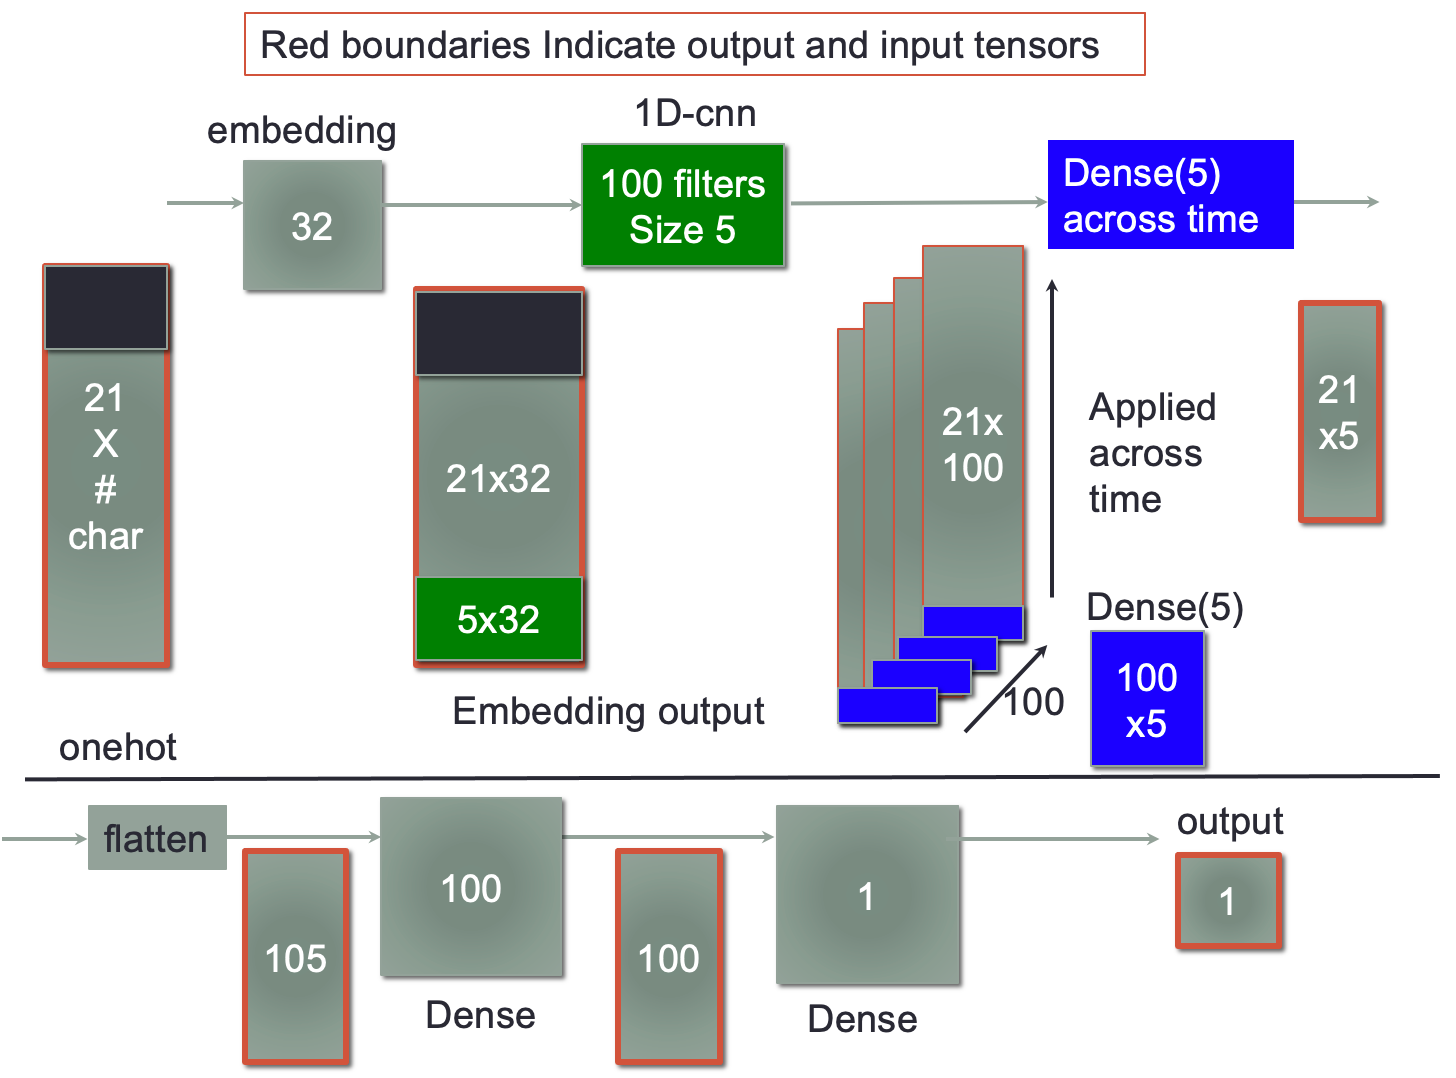


Note you need to flatten the tensor before the final fully connected layer because of dimension mis-match. The tensor could be reshaped using the `view` method.

Do consult PyTorch documentation on how to use [embedding layers](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) and [1D-cnn](https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html).

Hint: to apply dense5 across the time dimension you should read about how the multiplication in the dense layer is applied. The output of the 1D-cnn should be [batch x nfilter x sequence length]. We want to apply the dense5 (a weight matrix of size 100 x 5) by multiplying the same set of numbers over the nfilter dimension repeated over the sequence length (this can be possible via broadcasting) which should give an output of [batch x 5 x sequence length]. You might want to use the function [transpose](https://pytorch.org/docs/stable/generated/torch.transpose.html) somehow.

Even more hints: https://stackoverflow.com/questions/58587057/multi-dimensional-inputs-in-pytorch-linear-method


In [ ]:
################################################################################
# TODO#5:                                                                      #
# Write a function that returns convolution nueral network model.              #
# You can choose any normalization methods, activation function, as well as    #
# any hyperparameter the way you want. Your goal is to predict a score         #
# between [0,1] for each input whether it is the beginning of the word or not. #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################

class SimpleCNN(torch.nn.Module):
  pass

In [ ]:
################################################################################
# TODO#6:                                                                      #
# Write code that performs a training process. Select your batch size carefully#
# as it will affect your model's ability to converge and                       #
# time needed for one epoch.                                                   #
################################################################################
model_conv1d_nn = SimpleCNN().cuda()
summary(model_conv1d_nn,  input_size=(64, 21), device='cuda') #summarize the model
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################


In [ ]:
result = evaluate(test_loader, model_conv1d_nn)
print(result)

# Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available. Remember that training time increases with the complexity of the model. You might find wandb helpful in tuning of complicated models.

Your model should be better than your CNN or GRU model in the previous sections.

Some ideas to try
1. Tune the parameters
2. Recurrent models
3. CNN-GRU model
4. Improve the learning rate scheduling

In [ ]:
################################################################################
# TODO#7                                                                       #
# Write a class that returns your best model. You can use anything             #
# you want. The goal here is to create the best model you can think of.        #
# Your model should get f-score more than 97% from calling evaluate().         #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################

class BestModel(torch.nn.Module):
  pass

In [ ]:
################################################################################
# TODO#8                                                                      #
# Write code that perform a trainin loop on this dataset. Select your          #
# batch size carefully as it will affect your model's ability to converge and  #
# time needed for one epoch.                                                   #
#                                                                              #
################################################################################
print('start training')
my_best_model = BestModel()
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

In [ ]:
evaluate(test_loader, my_best_model)